In this iPython notebook, we **run logistic regression**. 

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Import data</h3>

In [2]:
CELLNAME = "GM12878"
label = "p300"
add_interactions = False
standardize = True

In [3]:
data = pd.read_table('data/' + CELLNAME + '_features_2.txt.gz', compression='gzip')
data.head(2)

,chr,lower,upper,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H4K20me1,p300,eRNA,tfbs,DRM,DNase
0,1,1,200,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,201,400,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
feature_names = list(data.columns.values)
feature_names = feature_names[3:]
feature_names.remove(label)
print feature_names

['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1', 'eRNA', 'tfbs', 'DRM', 'DNase']


In [5]:
#Select positive set
positive = data[data[label]==1]
nrows = positive.shape[0]
print positive.shape

#Select negative set
use_random_sampling = False 
if use_random_sampling:
    negative = data[data[label]==0].as_matrix()
    nrows = negative.shape[0]
    select = np.random.choice(nrows, positive.shape[0]) # same size as positive set
    negative = negative[select,:]
    print negative.shape
else: # follow distribution of positive set
    indices = data[data[label]==1].index.values
    diff = np.diff(indices)
    offset = np.floor(np.mean(np.diff(indices))/2)
    select = (indices)+offset.astype(np.int64)
    mean_distance = np.mean(np.diff(indices))*200 # approximate value
    negative = data.iloc[select]
    negative = negative[negative[label]==0]
    print negative.shape

#Form sample
sample = pd.concat([positive,negative])
print sample.shape

(113883, 16)
(107085, 16)
(220968, 16)


In [6]:
X = sample.drop(['chr','lower','upper',label], axis=1).as_matrix()
if add_interactions:
    X = PolynomialFeatures(interaction_only=True).fit_transform(X) 
    X = X[:,1:]
    print X.shape
    feature_names = feature_names + list(itertools.combinations(feature_names,2))
if standardize:
    X = scale(X.astype(float))
print X

[[-0.53346569 -0.18025871 -0.2971135  ..., -0.47490737 -0.33744318
  -0.65734658]
 [-0.53346569 -0.18025871 -0.2971135  ..., -0.47490737 -0.33744318
  -0.65734658]
 [-0.53346569 -0.18025871 -0.2971135  ..., -0.47490737 -0.33744318
  -0.65734658]
 ..., 
 [-0.53346569 -0.18025871 -0.2971135  ..., -0.47490737 -0.33744318
  -0.65734658]
 [-0.53346569 -0.18025871 -0.2971135  ...,  2.10567377 -0.33744318
  -0.65734658]
 [-0.53346569 -0.18025871 -0.2971135  ..., -0.47490737 -0.33744318
  -0.65734658]]


In [7]:
y = sample[label].as_matrix()
print y

[1 1 1 ..., 0 0 0]


In [8]:
print "Correlation between each feature and %s (Pearson corr coef)" %label
for i in range(len(list(data.columns.values))-4):
    print feature_names[i] + ": " + "%s" %stats.pearsonr(X[:,i], y)[0]

Correlation between each feature and p300 (Pearson corr coef)
H3K27ac: 0.348285510703
H3K27me3: 0.100417537633
H3K36me3: 0.0763629313715
H3K4me1: 0.332559484245
H3K4me2: 0.386937800594
H3K4me3: 0.354356924876
H3K9ac: 0.300208255893
H4K20me1: 0.118452444769
eRNA: 0.16743502311
tfbs: 0.0822085285811
DRM: 0.220326823482
DNase: 0.409328309308


<h3>Run Logistic Regression</h3>

0.722964658353


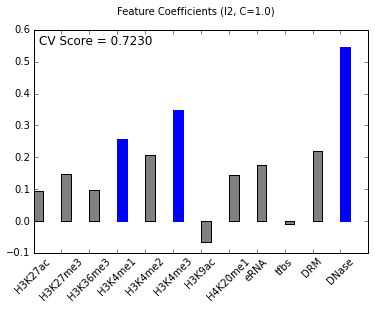

0.722905824175


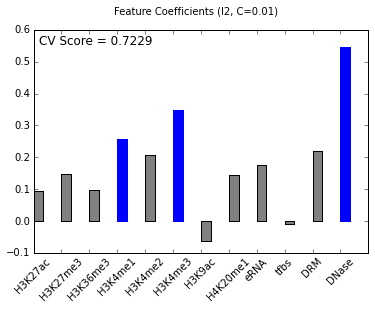

0.720457476821


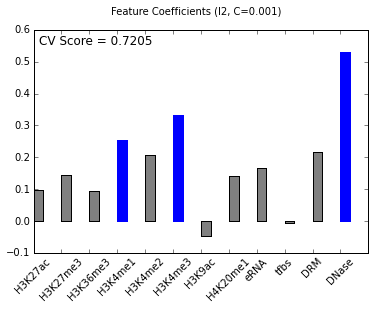

0.720000368636


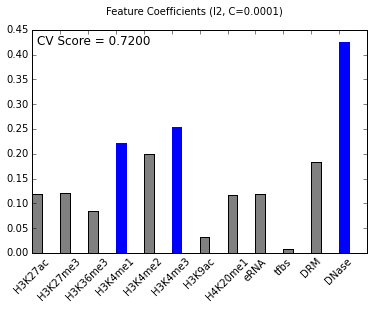

0.714882049915


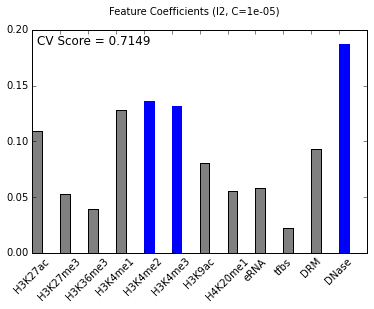

0.714719142317


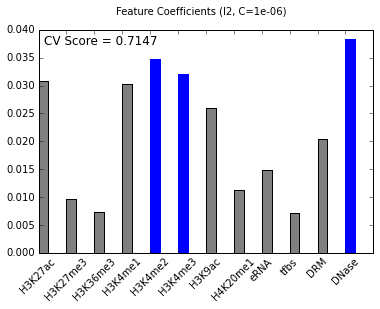

In [20]:
penalty_type = 'l2'
regs = [1.0, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
for reg in regs: 
    logreg = linear_model.LogisticRegression(penalty=penalty_type, C=reg)
    logreg.fit(X,y)
    scores = cross_validation.cross_val_score(logreg, X, y, cv=10)
    mean_cv = sum(scores) / float(len(scores))
    print mean_cv

    coef = logreg.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:3]
    if add_interactions:
        for i in top_coef:
            print feature_names[i]

    #Plot
    ind = np.arange(X.shape[1])  
    width = 0.35       
    fig, ax = plt.subplots()
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top_coef:
        rects[index].set_color('b')
    plt.xticks(range(X.shape[1]))
    if not add_interactions:
        ax.set_xticklabels(feature_names,rotation=45)
    else:
        ax.set_xticklabels([])
    plt.suptitle("Feature Coefficients (%s, C=%s)" %(penalty_type,reg))
    ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
    plt.show()

Elastic Net (learned with Stochastic Gradient Descent) [unfinished work]

In [33]:
alphas = [1.0, 0.5, 0.2, 0.1, 0.08]
for a in alphas:
    logregen = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=a, l1_ratio=0.15)
    logregen.fit(X,y)
    scores = cross_validation.cross_val_score(logregen, X, y, cv=10)
    mean_cv = sum(scores) / float(len(scores))
    print (a, mean_cv)

(1.0, 0.51538231786658284)
(0.5, 0.51538231786658284)
(0.2, 0.71529360223168115)
(0.1, 0.71196295479238836)
(0.08, 0.71202631549569984)
